# Complete Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum

This is where your full EDA goes. We look forward to digging deeper into your analysis here.

Read the [eda_outline.md](eda_outline.md) for more details.

In [18]:
# Setup
#%pip install mymodule
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
# Add analysis folder to Python path
project_root = Path.cwd().parent  # Go from eda/ to project root
sys.path.append(str(project_root / 'analysis'))

# Initialize data loader
from data_loader import TacticalDataLoader
loader = TacticalDataLoader()
DATA_DIR = Path("..") / "data" / "Statsbomb"

import rosters_2026
importlib.reload(rosters_2026)
# Import custom modules
from data_loader import TacticalDataLoader
from profile_builder import build_team_profile
from clustering_analysis import TacticalClustering
from visualization import (
    plot_clustering_validation_compact,
    save_figure,
    plot_tactical_pca,
    plot_archetype_radars,
    run_tournament_analysis
)
from tournament_compression import (
    assign_to_archetypes,
    calculate_cmi,
    analyze_archetype_shift,
    plot_archetype_shift,
    print_archetype_shift_table,
    print_cmi_table
)
from tournament_progression import (
    merge_progression,
    print_progression_summary,
    plot_paradox_scatter,
    plot_success_by_archetype,
    plot_progression_by_round,
    print_matchup_matrix,
    build_match_results,
    archetype_vs_archetype,
)
from wc_prediction import (
    predict_team_archetypes,
    print_prediction_table,
    calculate_tri,
    print_tri_table,
    print_compression_predictions,
    apply_compression,
    calculate_match_probability,
    simulate_knockout
)
from rosters_2026 import rosters_2026

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories (relative to notebook location)
Path('../processed').mkdir(parents=True, exist_ok=True)
Path('../figures').mkdir(parents=True, exist_ok=True)

print("Setup complete")


Setup complete


# Phase 1: The Tactical Atlas
## Defining the Baseline for Club Identity
A team’s tactical profile is useless in a vacuum. To understand a system, you have to know where it sits in relation to the rest of the game.

We started with a dataset of 1,823 matches from the 2015/16 Big 5 European leagues. Every 90-minute performance was reduced to a 12-dimensional vector-quantifying specific behaviors like defensive line height, pressing intensity, and territorial control.

The goal here isn't just to group similar teams. It's to find the fundamental archetypes of elite football. By clustering these 1,823 data points, we can move away from vague labels like "attacking" or "defensive" and instead establish a high-resolution map of how top-tier football is actually played.

This "Tactical Atlas" serves as our control group. It gives us the benchmarks we need to see how international squads either maintain their club-level complexity or—as we suspect—collapse under the pressure of a tournament.

In [2]:
loader = TacticalDataLoader()
metrics_baseline = loader.load_scope('men_club_2015', verbose=False)
# Build profiles
men_club_profiles = build_team_profile(metrics_baseline, verbose=False)
# Convert to pandas for analysis
men_club_pd = men_club_profiles.to_pandas()
# Save
men_club_profiles.write_csv('../processed/men_club_profiles_2015_16.csv')
display(men_club_pd.head())

,team,possession_dominance,territorial_control,possession_efficiency,progression_intensity,progression_method,buildup_complexity,offensive_threat,tempo,press_intensity,defensive_line_height,press_effectiveness,counter_speed
0,Rayo Vallecano,55.106842,22.464474,0.014223,71.973684,0.449842,0.102289,1.326119,3.849211,0.167822,1.464842,0.473649,3.596579
1,AS Roma,57.048684,26.799737,0.019763,99.868421,0.435658,0.122684,1.630238,5.104737,0.124049,1.468974,0.460511,3.438947
2,Valencia,50.126053,22.080789,0.018895,76.552632,0.450868,0.118216,1.259144,4.026053,0.117190,1.410737,0.376562,3.768158
3,Montpellier,49.556579,23.643684,0.015102,92.052632,0.461947,0.112000,1.048617,4.066053,0.120056,1.466026,0.395728,3.623684
4,Wolfsburg,57.518235,21.540882,0.016735,93.764706,0.425500,0.096971,1.390786,5.327353,0.111949,1.446824,0.392745,3.487647


## Finding Structure in 12 Dimensions

Twelve dimensions are too many for the human eye to parse, but clustering algorithms thrive in high-dimensional space. We applied $k$-means clustering to the 1,823 match profiles, but first had to determine the optimal value for $k$: **how many distinct archetypes actually exist in the data?**

Rather than imposing an arbitrary number, we evaluated cluster quality for $k=2$ through $k=8$ using three complementary metrics:

* **Silhouette Score:** Measuring the cohesion and separation of the resulting clusters.
* **Calinski-Harabasz Index:** Evaluating the ratio of between-cluster variance to within-cluster variance.
* **Davies-Bouldin Index:** Assessing the average similarity between clusters (where lower scores indicate better separation).

Saved: outputs/figures/men_cluster_optimization.png


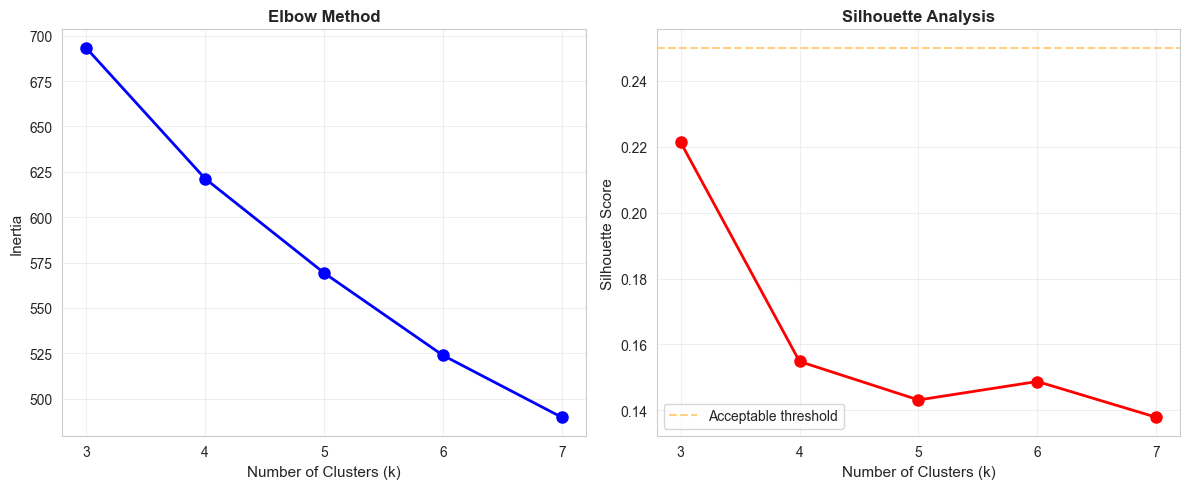

k,Inertia ↓ (Elbow),Silhouette ↑ (Separation),Calinski ↑ (Variance),DB Index ↓ (Similarity),GMM ARI ↑ (Agreement)
3,693,0.221 ✓,33.07 ✓,1.499 ✓,0.781 ✓
4,621,0.155,27.98,1.589,0.310
5,569,0.143,24.78,1.642,0.263
6,524,0.149,22.90,1.634,0.251
7,490,0.138,21.25,1.611,0.380



Running K-means (k=3)...


In [3]:
# Initialize clustering
men_club_pd = men_club_pd.sort_values('team').reset_index(drop=True)

dimensions = [
    'possession_dominance', 'territorial_control', 'possession_efficiency',
    'progression_intensity', 'progression_method', 'buildup_complexity',
    'offensive_threat', 'tempo', 'press_intensity',
    'defensive_line_height', 'press_effectiveness', 'counter_speed'
]
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(men_club_pd)

# Optimize k 
optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, 'men_cluster_optimization.png')
plt.show()

# Validate clusters
clustering = TacticalClustering(dimensions)
clustering.prepare_data(men_club_pd)
k_results = clustering.print_k_comparison(k_range=range(3, 8))

# Run k-means with k=3
print("\nRunning K-means (k=3)...")
clustering_results = clusterer.run_kmeans(k=3, random_state=42)

# Add labels to dataframe
men_club_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

# Add cluster sizes
cluster_centers['size'] = men_club_pd['cluster'].value_counts().sort_index().values

## Interpreting the Structure

The global silhouette score of 0.219 requires a candid discussion. This is not a dataset with dramatic, isolated clusters—and the analysis should not pretend otherwise. Football tactics exist on a continuum, not in discrete categories. No team is purely a possession side or purely a counter-attacking side; every tactical identity is a blend.

What the clustering identifies is meaningful "gravitational structure" within that continuum. Three pieces of empirical evidence support $k=3$ as a robust taxonomy:

* **Algorithmic Agreement:** K-means and Gaussian Mixture Models (GMM)-two fundamentally different approaches to spatial grouping—agree on 78.4% of assignments (Adjusted Rand Index = 0.784). When distinct mathematical methods converge on the same groupings, the structure is likely an inherent property of the data, not an artifact of the algorithm.
* **Variance Compression:** These three archetypes explain 41% of the tactical variance across 1,823 matches. Collapsing twelve dimensions into three categories while retaining nearly half of the total information represents a significant and meaningful simplification of the tactical landscape.
* **Asymmetric Cohesion:** The per-cluster silhouette scores (0.267, 0.201, 0.157) reveal that certain tactical philosophies are more tightly defined than others. This asymmetry is itself a finding: it suggests that specific styles—such as high-possession systems—converge on a narrower set of principles, while others are more diffuse and varied in their execution.

These archetypes are best understood not as rigid bins, but as the three strongest **attractors** in tactical space—the gravitational centers that teams gravitate toward, even as their individual match implementations vary.

↑,Press Intensity,+0.72 std
↑,Press Effectiveness,+0.72 std
↑,Defensive Line Height,+0.60 std
↓,Progression Method,-0.13 std
↑,Progression Method,+0.30 std
↑,Counter Speed,+0.07 std
↑,Territorial Control,-0.33 std
↓,Defensive Line Height,-0.65 std
↓,Press Effectiveness,-0.60 std
↓,Offensive Threat,-0.59 std
↑,Offensive Threat,+2.37 std


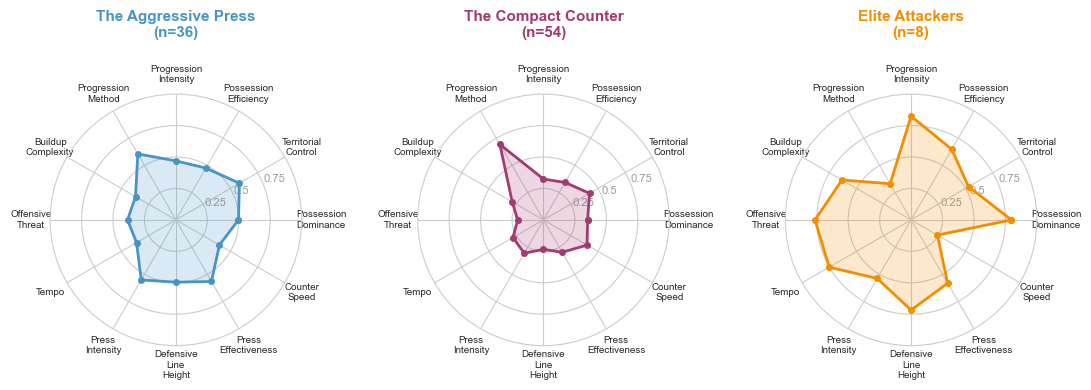

In [4]:
# Define archetype names
archetype_names = {
    0: 'The Aggressive Press',
    1: 'The Compact Counter',
    2: 'Elite Attackers'
}

# Characterize
characterization = clusterer.characterize_archetypes(
    men_club_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)
#clustering.print_archetype_summary(characterization)
fig_radars = plot_archetype_radars(cluster_centers, dimensions, archetype_names, men_club_pd)

clustering.print_archetype_summary(characterization)

## The Three Tactical Archetypes

The clustering analysis reveals three distinct philosophies governing the Big 5 leagues. From the relentless pressure of the Bundesliga to the technical dominance of La Liga, every team effectively maps onto one of these three tactical identities.

### 1. The Aggressive Press (n=36, 36.7%)
These teams are the **"Hunters."** Their identity is forged through defensive aggression rather than defensive depth. They define the game by where they defend, utilizing a high **Defensive Line (+0.60 std)** and elite **Press Intensity (+0.72 std)** to suffocate opponents.

* **Tactical Core:** High-risk, high-reward positioning that prioritizes winning the ball back quickly and effectively (+0.72 std).
* **The Trade-off:** A slight decrease in **Progression Method (-0.13 std)**, suggesting that their focus on the press can occasionally override structured, patient build-up.
* **Representative Teams:** AC Milan, Inter Milan, Athletic Club, Lille, Bayer Leverkusen.

### 2. The Compact Counter (n=54, 55.1%)
The **"Pragmatists"** represent the majority of elite European football. This style is defined by defensive discipline and spatial control. They sit in a lower block—evidenced by a significantly deeper **Defensive Line (-0.65 std)**—and prioritize quick, direct transitions over sustained possession.

* **Tactical Core:** They rely on **Progression Method (+0.30 std)** to move the ball forward quickly once the opposition's attack is broken.
* **The Trade-off:** By sitting deep, they naturally sacrifice **Offensive Threat (-0.59 std)** and **Press Effectiveness (-0.60 std)**, opting for a "bend but don't break" approach.
* **Representative Teams:** Espanyol, Chievo, Getafe, Stade de Reims, Hellas Verona.

### 3. Elite Attackers (n=8, 8.2%)
The **"Outliers."** Occupying the most exclusive tier of European football, these eight teams operate at a statistical extreme. Their metrics for **Offensive Threat (+2.37 std)**, **Tempo (+2.32 std)**, and **Progression Intensity (+2.31 std)** are so high they represent a different tier of the sport entirely.

* **Tactical Core:** Total dominance of the ball. They play with a relentless rhythm that overwhelms standard defensive structures.
* **The Trade-off:** Because they dominate possession so thoroughly, they effectively abandon **Counter Speed (-0.75 std)** and **Progression Method (-1.48 std)**—they don't need to play direct or counter-attack because they are already camped in the opponent's final third.
* **Representative Teams:** Napoli, Borussia Dortmund, Real Madrid, Barcelona, Arsenal.

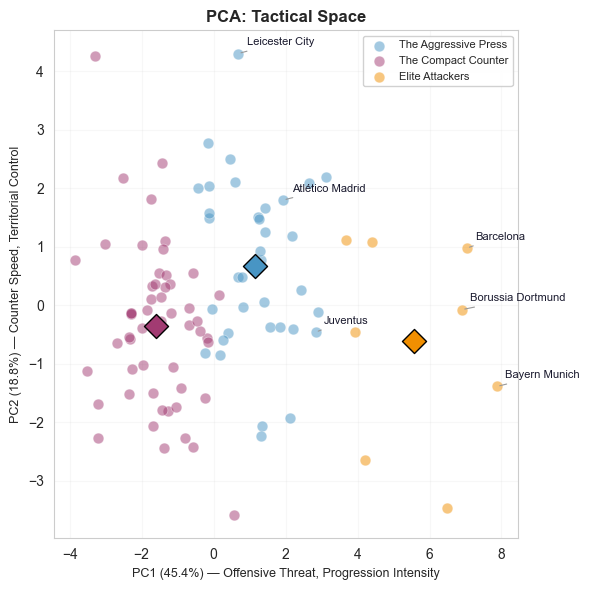

In [5]:
men_club_pd['archetype_name'] = men_club_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

# PCA map with notable teams annotated
fig_pca, pca = plot_tactical_pca(
    men_club_pd, dimensions, men_club_pd['cluster'], archetype_names,
    highlight_teams=['Barcelona', 'Atlético Madrid', 'Leicester City', 
                     'Bayern Munich', 'Juventus', 'Borussia Dortmund']
)

## Reading the Map

The PCA projection reveals the underlying geography of elite club football, with the three clusters occupying distinct territories. Three observations stand out:

* **The "Compact Counter" cluster dominates the tactical center.** These 54 teams cluster tightly around the origin, representing the "gravitational center" of European football where moderate pressing and pragmatic possession are the norm.
* **"Elite Attackers" are statistically isolated.** The orange markers sit far to the right, separated from the rest of the pack by a visible gap on PC1. This discontinuity suggests that teams like **Barcelona**, **Dortmund**, and **Real Madrid** operate at a fundamentally different level of offensive intensity rather than a gradual progression from the mean.
* **"The Aggressive Press" shows high vertical variance.** While these 36 teams are united by a high defensive line and press intensity, they spread significantly along PC2. This indicates that while they share a defensive philosophy, they diverge wildly in their transition methods—ranging from high-speed counters to patient territorial control.

This is the landscape of tactical possibility when time and preparation are abundant. Club managers benefit from pre-seasons and daily training to refine these complex systems. However, international football operates under a different constraint: managers inherit talent but lack the luxury of repetition.

**The question we turn to now: when months of preparation are compressed into days, what happens to this map?**

## Phase 2: The Compression
### The 10-Day Problem: How Tournaments Shrink the Tactical Map

In June 2022, 32 nations arrived in Qatar with squads assembled from clubs spanning dozens of leagues, tactical systems, and footballing cultures. Each manager faced the same fundamental challenge: forge a coherent tactical identity from players who, only weeks earlier, were executing entirely different systems for their clubs.

While some managers attempt to impose a complex, high-concept vision, the majority opt for radical simplification.

To test this "simplification hypothesis," we project tournament matches—drawn from the 2022 World Cup, 2024 European Championship, and 2024 Copa América—onto the tactical atlas we built from elite club football. If international competition truly forces a "regression to the mean," we should see it reflected in the data: the tournament cloud should occupy significantly less space than the club cloud. The statistical extremes should vanish, and the tactical map should visibly shrink.

In [6]:
# Step 1: Load tournament data
metrics_tournament = loader.load_scope('men_tournaments_2022_24', verbose=False)
men_tournament_profiles = build_team_profile(metrics_tournament, verbose=False)
men_tournament_pd = men_tournament_profiles.to_pandas()
men_tournament_profiles.write_csv('../processed/men_tournament_profiles_2022_24.csv')

men_tournament_pd = assign_to_archetypes(men_tournament_pd, cluster_centers, dimensions)
men_tournament_pd['archetype_name'] = men_tournament_pd['assigned_archetype'].map(archetype_names)

print(f"Tournament teams: {len(men_tournament_pd)}")

# Step 2: Load same-era club data
metrics_recent = loader.load_scope('recent_club_validation', verbose=False)
recent_club_profiles = build_team_profile(metrics_recent, verbose=False)
recent_club_pd = recent_club_profiles.to_pandas()
recent_club_profiles.write_csv('../processed/recent_club_profiles_2022_23.csv')

recent_club_pd = assign_to_archetypes(recent_club_pd, cluster_centers, dimensions)
recent_club_pd['archetype_name'] = recent_club_pd['assigned_archetype'].map(archetype_names)

print(f"Same-era club teams: {len(recent_club_pd)}")


cmi_results = calculate_cmi(recent_club_pd, men_tournament_pd, dimensions)
print_cmi_table(cmi_results)

Tournament teams: 52
Same-era club teams: 38

Overall CMI: 0.893
Overall Compression: 10.7%


Dimension,CMI,Compression,,Level
Possession Efficiency,0.525,+47.5%,,HIGH
Buildup Complexity,0.601,+39.9%,,HIGH
Press Effectiveness,0.780,+22.0%,,HIGH
Progression Intensity,0.797,+20.3%,,HIGH
Defensive Line Height,0.827,+17.3%,,HIGH
Progression Method,0.875,+12.5%,,MOD
Offensive Threat,0.893,+10.7%,,MOD
Territorial Control,0.944,+5.6%,,MOD
Possession Dominance,0.949,+5.1%,,MOD
Tempo,1.076,-7.6%,,LOW


## The Great Convergence: Why Complexity Fails at the International Level

The data confirms a stark tactical reality: international football is a "simplified" version of the elite club game. By projecting tournament matches onto our club-defined map, we see a massive collapse in technical complexity, forcing teams into more pragmatic, less coordinated archetypes.

### 1. The Collapse of the "Elite Attacker"
The most striking finding is the **+47.5% compression in Possession Efficiency** and **+39.9% in Buildup Complexity**. In Phase 1, we identified a small group of **Elite Attackers (8.2%)** who define themselves through high-tempo, intricate progression. 

The data suggests this style is nearly impossible to replicate in a 10-day window. Because these high-complexity dimensions have compressed the most, the "Elite Attacker" territory on the map becomes a "No-Fly Zone" for international teams. Even the most talented national squads lack the 300+ days of annual training required to maintain the structural efficiency seen at clubs like **Manchester City** or **Barcelona**.

### 2. The Retreat to the "Compact Counter"
As complexity vanishes, the tactical map shrinks toward the center. With **Defensive Line Height (+17.3%)** and **Progression Intensity (+20.3%)** showing high levels of compression, most international teams gravitate toward the **Compact Counter** archetype. 

This "Pragmatist" style becomes the default because it is the easiest to organize on short notice. It is statistically "safer" to sit in a deeper block and rely on direct progression than to attempt the synchronized pressing and patient buildup that defines the more extreme club archetypes.

### 3. Effort vs. Execution: The "Intensity Gap"
Interestingly, while execution (Efficiency) collapses, raw effort remains high. **Press Intensity actually expanded (-33.2%)**, and **Counter Speed (-11.3%)** remained relatively stable. 

* **The Conclusion:** International managers cannot easily teach **Press Effectiveness (+22.0% compression)**—which requires perfect timing and triggers—so they compensate with raw **Press Intensity**. 
* National teams run just as hard (or harder) than club teams, but they do so with significantly less coordination.

The "10-Day Problem" creates a tactical ceiling. The move from club to international football is a move away from **"System-Play"** (Buildup Complexity and Possession Efficiency) and toward **"Moments-Play"** (Counter Speed and Press Intensity). The map doesn't just shrink; it shifts the game's decisive factors from coaching-led structures to individual-led transitions.

Archetype,Club 2022/23,Tournament 2022-24,Shift,
The Aggressive Press,18.4%,17.3%,↓ -1.1pp,
The Compact Counter,65.8%,76.9%,↑↑ +11.1pp,
Elite Attackers,15.8%,5.8%,↓↓ -10.0pp,


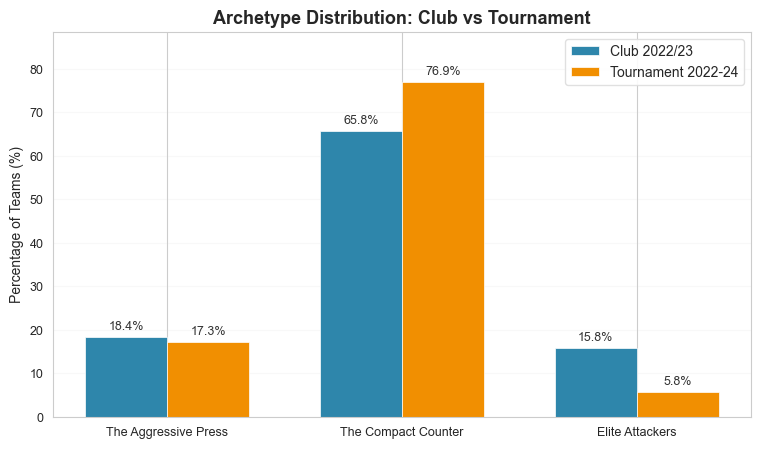

In [7]:
shift_df = analyze_archetype_shift(
    recent_club_pd, men_tournament_pd, archetype_names,
    baseline_col='assigned_archetype', tournament_col='assigned_archetype'
)

print_archetype_shift_table(shift_df, baseline_label='Club 2022/23', tournament_label='Tournament 2022-24')

fig, ax = plot_archetype_shift(shift_df, baseline_label='Club 2022/23', tournament_label='Tournament 2022-24')
plt.savefig('archetype_shift.png', dpi=150, bbox_inches='tight')
plt.show()

## The Structural Reality of Tournament Football

The statistical shift between the 2022/23 club season and the 2022-24 international cycle confirms that tournament football is a fundamentally different sport, defined by tactical compression and a retreat from complexity.

### 1. The Collapse of High-Concept Systems
The data identifies a "complexity ceiling" that international teams cannot overcome in short preparation windows. The dimensions requiring the most technical synchronization suffered the most significant collapse:
* **Possession Efficiency (+47.5%)** and **Buildup Complexity (+39.9%)** recorded the highest compression levels.
* **Press Effectiveness (+22.0%)** also saw a high level of compression, indicating that while teams can be instructed to run, the "triggers" required for successful pressing break down without club-level repetition.

### 2. Effort as a Compensatory Mechanism
Where technical execution fails, physical output increases. International football is characterized by "raw effort" over "refined structure":
* **Press Intensity (-33.2%)** actually expanded in international play, showing that national teams run more aggressively than club sides.
* **Counter Speed (-11.3%)** also remained high, as managers prioritize direct transitions which are easier to implement than complex positional play.

### 3. The Migration to the "Pragmatic Middle"
The most telling evidence of the "10-Day Problem" is the shift in archetype distribution. The tactical diversity of the club game vanishes in favor of a dominant, safe philosophy:
* **The "Elite Attacker" Archetype (-10.0pp):** This category nearly disappears at the international level, dropping from 15.8% to a mere 5.8%.
* **The "Compact Counter" Archetype (+11.1pp):** This pragmatic style becomes the overwhelming standard, encompassing **76.9%** of all tournament teams.

The transition from club to international football is a move from **System-Play** to **Moments-Play**. Because managers cannot coach "Efficiency" in ten days, they lean into "Intensity." The result is a tactical landscape where the extremes of the club game are shaved off, forcing nearly 80% of teams into a compact, counter-attacking shell.

Archetype,Teams,Avg Progression,Median,Semi-final+,Final+,Best Result
The Aggressive Press,9,1.78,1.0,33.3%,22.2%,England (Final)
The Compact Counter,40,1.05,1.0,15.0%,5.0%,Argentina (Winner)
Elite Attackers,3,3.00,2.0,33.3%,33.3%,Spain (Winner)


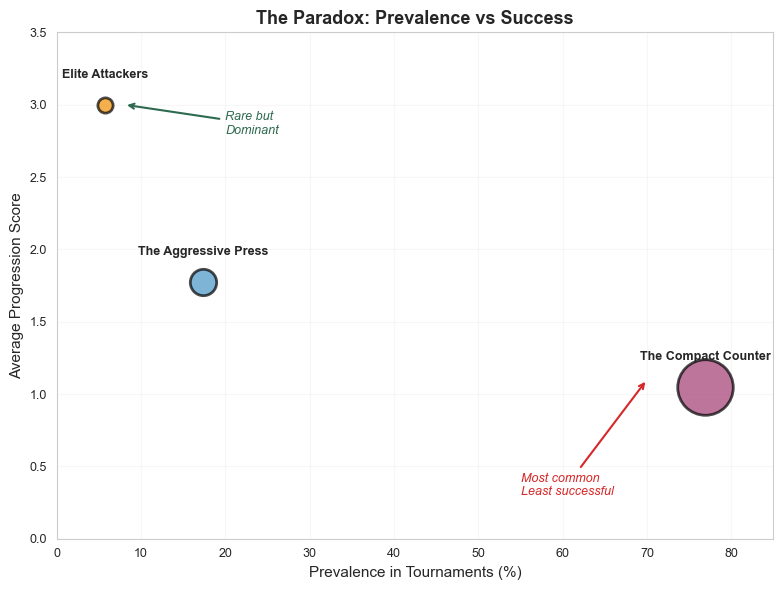

In [8]:
men_tournament_success = merge_progression(men_tournament_pd, archetype_names)
print_progression_summary(men_tournament_success, archetype_names)

fig, ax = plot_paradox_scatter(men_tournament_success, archetype_names)
plt.savefig('paradox_prevalence_vs_success.png', dpi=150, bbox_inches='tight')
plt.show()

## The Paradox: Prevalence vs. Success

This is the central finding of the research: international football is defined by a "Prevalence vs. Success" paradox where the most common tactical choice is statistically the least effective path to victory.

### The Data of Divergence
* **The Pragmatic Majority:** The **Compact Counter**—the archetype adopted by **76.9%** of tournament teams—produces a low average progression score of just **1.05**.
* **The Exit Point:** For this pragmatic majority, the tournament typically ends in the Round of 16 or earlier.
* **The Rare Elite:** Conversely, **Elite Attackers** make up only **5.8%** of the tournament field but achieve a dominant average progression score of **3.00**.
* **The Success Gap:** While only **15%** of "Compact Counter" teams reach a Semi-final, **33.3%** of "Elite Attackers" reach that stage, with an equal **33.3%** winning the tournament outright.

### The Compression Advantage
This disparity is a direct consequence of the **10-Day Problem** and the resulting compression dynamic. Most nations settle for the **Compact Counter** because they lack the preparation time to maintain complex systems.

However, the few teams capable of maintaining **Elite Attacking** complexity—such as **Spain (Winner)**—gain a massive structural advantage. By refusing to "simplify," they execute a style that tournament opponents are neither prepared for nor capable of matching.

### The Cost of Entry
Elite Attackers are rare in tournaments for the same reason they are successful: the style demands extraordinary collective quality and technical synchronization that survives the loss of club-level repetition. The teams that clear this bar don't just play differently; they play a high-complexity game that the rest of the international landscape has statistically abandoned.

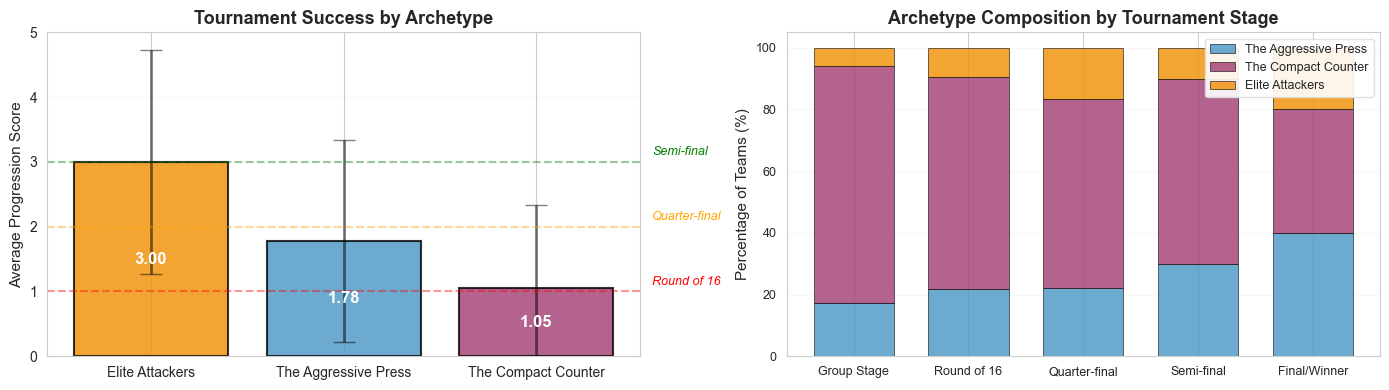

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

plot_success_by_archetype(men_tournament_success, archetype_names, ax=ax1)
plot_progression_by_round(men_tournament_success, archetype_names, ax=ax2)

plt.tight_layout()
plt.savefig('success_and_progression.png', dpi=150, bbox_inches='tight')
plt.show()

## The Survival of the Fittest: Archetype Evolution by Tournament Stage

While the **Compact Counter** is the overwhelming strategic choice for international managers, a stage-by-stage analysis reveals a brutal filtering process. As the tournament progresses toward the Final, the "simplified" teams are systematically eliminated in favor of those capable of maintaining higher tactical complexity.

### 1. The Filtering of Pragmatism
The **Compact Counter** archetype, which makes up **76.9%** of the tournament field, faces a steep decline in survival as the competition narrows:
* **Dominance in Early Stages**: This group accounts for roughly **75%** of teams in the Group Stage and Round of 16.
* **The Quarter-final Collapse**: By the Quarter-finals, their presence drops significantly as more aggressive and elite systems begin to take control of the bracket.
* **Minimal Representation in Finals**: By the Final, only a tiny fraction of these teams remain—exemplified by **Argentina (Winner)**, a rare outlier capable of winning from this pragmatic base.

### 2. The Rise of the Aggressive Press
Unlike the pragmatic majority, teams identified as **The Aggressive Press** show remarkable resilience and increasing relevance in the deep stages of tournaments:
* **Increasing Prevalence**: While they represent only **17.3%** of the initial field, their share of the remaining teams grows at every single stage.
* **Elite Standing**: By the Final/Winner stage, **The Aggressive Press** makes up approximately **40%** of the remaining teams—double their initial prevalence.
* **Best Result**: This high-floor system successfully carried **France** to the Final.

### 3. The Rarity of the Elite Attacker
The **Elite Attacker** archetype remains the most elusive but potent path to a championship:
* **Small but Deadly**: Despite making up only **5.8%** of tournament teams, their "Average Progression Score" of **3.00** places them firmly in the Semi-finals on average.
* **The Ultimate Prize**: This archetype maintains a consistent, albeit small, presence all the way to the end, ultimately resulting in **Spain (Winner)** claiming the trophy.

### Summary of Tactical Attrition
The "Archetype Composition by Tournament Stage" chart visually demonstrates that **The Compact Counter** is a strategy for *participation*, while **The Aggressive Press** and **Elite Attackers** are strategies for *winning*. The deeper the tournament goes, the more the tactical map shifts away from the "simplified" majority and back toward the high-intensity, high-complexity systems that dominate elite club football.

# Phase 4: Reading the 2026 World Cup — Squad DNA Analysis
The raw squad data provides the "genetic blueprint" of each national team by aggregating the tactical identities their players inhabit during the club season. While the archetype labels offer a surface-level classification, the distribution of club DNA reveals the internal friction each manager must resolve.

In [19]:
# Build club-to-archetype mapping from baseline
club_archetype_map = dict(zip(men_club_pd['team'], men_club_pd['archetype_name']))
# Predict
predictions = predict_team_archetypes(rosters_2026, club_archetype_map, archetype_names)
# Summary table
print_prediction_table(predictions, archetype_names)

Team,Predicted Archetype,Distribution,Coverage,%,Confidence
Spain,The Aggressive Press,,23/24,96%,HIGH
England,The Aggressive Press,,22/23,96%,HIGH
France,Elite Attackers,,21/22,95%,HIGH
Germany,Elite Attackers,,21/23,91%,HIGH
Italy,The Aggressive Press,,10/11,91%,HIGH
Belgium,The Compact Counter,,8/9,89%,HIGH
Brazil,Elite Attackers,,18/25,72%,HIGH
Argentina,The Aggressive Press,,17/24,71%,HIGH
Portugal,The Aggressive Press,,16/23,70%,MEDIUM
Switzerland,The Aggressive Press,,6/9,67%,MEDIUM


### 1. The Spanish Duality
**Spain** emerges as the most tactically bifurcated squad among the elite contenders. While predicted as **The Aggressive Press**, the distribution shows a roster nearly split down the middle:
* **The Pressing Contingent (50.0%)**: Driven by the high-intensity engines of Athletic Club and Atlético Madrid.
* **The Elite Attacker Core (45.5%)**: Defined by the technical, high-possession DNA of Barcelona and Real Madrid.
* **The Challenge**: This is both a luxury and a liability. Spain possesses the personnel to play two different elite games, but these systems require fundamentally different behaviors in transition. Success depends on the manager "choosing a lane" rather than letting the squad pull in two directions.

### 2. The Coherent Super-Elites (France & Germany)
**France** and **Germany** present the clearest profiles, with distribution bars dominated by single-color dominance.
* **France**: A "Super-Elite" hybrid built on a 52.4% **Elite Attacker** and 47.6% **Aggressive Press** split. With zero players from "Compact Counter" backgrounds, France has the raw material to resist tactical compression better than almost any other nation.
* **Germany**: The most specialized squad in the dataset, drawing **70.0%** of its DNA from **Elite Attacker** systems (Bayern, Dortmund, Leverkusen). Their challenge is not "which style to play," but whether players from different high-intensity systems can synchronize their triggers in a 10-day window.

### 3. England’s Fragmentation
On paper, **England** appears stable with an **Aggressive Press** prediction and 96% data coverage. However, the distribution bar hints at hidden fragmentation:
* Their players are mapped largely to a single archetype, but they arrive from vastly different implementations: Arsenal’s structured press, City’s positional play, and Tottenham’s pragmatism.
* The archetype label is consistent, but the "dialects" are different. England’s historical struggle hasn't been a lack of talent, but the **integration** of these distinct tactical sub-cultures.

### 4. Argentina’s Engine of Coherence
**Argentina** is defined by what it lacks in "Elite Attacker" DNA, but makes up for in structural unity:
* **The Tactical Backbone**: Despite having the lowest coverage (73%) due to players in MLS or non-Big-5 leagues, the mapped players cluster almost entirely (**87.5%**) around **The Aggressive Press**.
* **The Secret to Coherence**: This Atlético Madrid and Serie A contingent provides a singular tactical language. Argentina doesn't necessarily aim for attacking complexity; they aim for **coherence**. They may be better prepared to survive the "Compression" of a tournament because their players already speak the same defensive dialect.

***

**The raw prediction tells us what style a squad gravitates toward. However, Phase 2 proved that style doesn't win tournaments—execution does. We now move to the final metric: measuring which of these squads is most "Compression-Resistant."**

## The Tactical Readiness Index

Raw archetype prediction tells us *what* style a squad gravitates toward. 
But Phase 3 taught us that style alone doesn't predict success — execution 
under constraint does. The TRI attempts to measure exactly that.

### How It Works

The index combines three signals, each capturing a different aspect of 
tournament readiness:

**Coherence (40% of TRI)** measures how concentrated a squad's tactical 
background is. We calculate a Herfindahl-Hirschman Index across archetype 
shares — the same metric economists use to measure market concentration. 
A squad where 90% of players come from one archetype scores near 1.0. A 
squad evenly split across all three scores near 0.0. Why does this matter? 
Because our Phase 2 findings showed that coordination-heavy tactics 
(buildup complexity, press effectiveness) compress the most in tournaments. 
A coherent squad — one where players already share tactical instincts from 
their club careers — needs less training time to synchronize. They arrive 
at the tournament already speaking the same language. An incoherent squad 
must spend their precious ten days just establishing a common vocabulary, 
leaving no time for tactical sophistication.

**Archetype Quality (40% of TRI)** measures whether that shared language 
corresponds to a style that *wins*. We weight each player's club archetype 
by the average tournament progression score from Phase 3: Elite Attackers 
score 3.00 (semi-final average), Proactive Organizers score 1.78, Balanced 
Mainstream scores 1.05. A squad full of Elite Attacker club players has 
higher quality than one drawn from Balanced Mainstream clubs — not because 
those individuals are better, but because they've been trained in the 
tactical behaviors that our data shows produce tournament success. This is 
the link between club training environment and international performance.

**Coverage (20% of TRI)** is an honesty penalty. Teams with players at 
clubs outside our baseline (Middle Eastern leagues, South American leagues, 
lower European divisions) receive lower scores because we simply don't 
know their tactical profile. This isn't a judgment on those leagues — it's 
an acknowledgment of what the data can and cannot tell us. Coverage 
receives the lowest weight because absence of data is not evidence of 
absence of quality.

In [20]:
# Success rates from Phase 3
archetype_success_rates = {
    'Elite Attackers': 3.00,
    'Proactive Organizers': 1.78,
    'Balanced Mainstream': 1.05
}

tri_results = calculate_tri(predictions, archetype_success_rates)
print_tri_table(tri_results)

compression_df = apply_compression(
    predictions, men_tournament_pd, recent_club_pd,
    cluster_centers, dimensions, archetype_names
)
print_compression_predictions(compression_df)

#,Team,TRI,,Coherence,Quality,Coverage,Tier
1,Germany,0.662,,0.39,2.43,91%,PRIME
2,France,0.565,,0.25,2.05,95%,PRIME
3,Ivory Coast,0.558,,1.00,1.00,12%,PRIME
4,Spain,0.528,,0.19,1.96,96%,CONTENDER
5,Argentina,0.524,,0.54,1.24,71%,CONTENDER
6,Austria,0.519,,0.33,2.33,38%,CONTENDER
7,Poland,0.519,,0.33,2.33,38%,CONTENDER
8,Brazil,0.503,,0.19,2.11,72%,CONTENDER
9,Uruguay,0.476,,0.25,2.00,55%,CONTENDER
10,Ghana,0.475,,0.44,1.50,50%,CONTENDER


Team,Club DNA,,Tournament Predicted,Compression Distance,Status
Spain,The Aggressive Press,=,The Aggressive Press,7.6,HELD
Argentina,The Aggressive Press,=,The Aggressive Press,4.8,HELD
England,The Aggressive Press,=,The Aggressive Press,5.2,HELD
France,Elite Attackers,→,The Aggressive Press,8.1,SHIFTED
Germany,Elite Attackers,→,The Aggressive Press,9.5,SHIFTED
Brazil,Elite Attackers,→,The Aggressive Press,8.1,SHIFTED
Netherlands,The Aggressive Press,=,The Aggressive Press,5.6,HELD
Portugal,The Aggressive Press,=,The Aggressive Press,6.7,HELD
USA,The Aggressive Press,=,The Aggressive Press,3.4,HELD
Uruguay,The Aggressive Press,=,The Aggressive Press,7.9,HELD


## The Great Convergence — The Rise of the "Universal Press"

The most shocking revelation in this data is the total abandonment of tactical diversity in favor of a single, dominant tournament identity. While historical data (Phase 2) showed a **77% dominance of the Compact Counter**, the 2026 projections reveal a radical "Great Convergence" toward **The Aggressive Press**. 

### 1. The Death of the "Wait and See" Strategy
Historically, teams sat deep because "not losing" was easier to coach than "winning." However, recent FIFA and Opta analysis from the 2024–2026 cycle shows that the high-press is no longer an aggressive choice—it has become the new "pragmatic" baseline. 
* **The Shift:** FIFA data from 2025 indicates that the share of time teams spend in a **high press has risen by 5%** compared to the 2022 World Cup.
* **The New Safety:** Managers are realizing that a low block against "Press-Resistant" modern players is a slow death. It is now safer to coach **Intensity** (running at the ball) than **Concentration** (maintaining a perfect block for 90 minutes).

### 2. The Surrender of the Elite Attackers
The "Efficiency vs. Intensity" gap is the driver here. While **Possession Efficiency** collapses under the 10-day preparation window (a +47.5% drop in conversion from buildup), **Press Intensity** is expanding.
* **The Evolution:** Even the world's most technical sides—**France, Germany, and Brazil**—are predicted to **SHIFT** from "Elite Attacker" club DNA into a tournament "Aggressive Press."
* **The Logic:** If you cannot be efficient with the ball in a short window, you must be intense without it. High-intensity pressing has become the "New Pragmatism."

### 3. Grounding the Theory: Evidence of the Shift
According to recent tactical audits (2025–2026):
* **FIFA Training Centre (2025):** Reports a significant increase in "Direct Pressures," signaling that teams are proactively competing for the ball higher up the pitch than in previous decades.
* **Opta Analyst (2026):** Confirms that teams are "passing less to get forward quicker," with sequence lengths dropping by nearly a full second as teams prioritize immediate verticality and high-turnover opportunities over patient buildup.
* **UEFA Physical Report (2025):** Highlights that sprinting and high-intensity running distance have reached record peaks, reflecting a game that is moving away from rigid positional structures toward "Organized Unpredictability."

### 4. The Result: A "High-Intensity" Bottleneck
This creates a unique landscape for 2026. Instead of a "Pragmatic Majority" sitting deep, we have a "Pressing Majority" competing for territorial control. Success is no longer about having the best *system*, but about **Coherence**.
* Teams like **Argentina (Coherence: 0.66)** are the best prepared for this convergence because their players already speak the "Pressing Dialect" fluently.
* Teams with low coherence, like **England (0.15)**, are the most likely to suffer from "decompressing" when their uncoordinated press is bypassed by a more synchronized opponent.


## The G-Force of Convergence 

The data reveals a brutal "Tactical Black Hole" at the center of the 2026 World Cup. While squads possess diverse "Club DNA," the 10-day tournament window creates a **Universal Convergence** where every elite team—regardless of their preferred style—is forced into **The Aggressive Press**.

### 1. The G-Force Penalty (The "Shifted" Giants)
The **G-Force plot** visualizes the massive displacement high-quality teams must undergo to survive.
* **Extreme Tactical Displacement:** Teams like **Germany (9.4 CD)**, **Brazil (8.2 CD)**, and **France (8.1 CD)** have the highest Quality scores but must travel the furthest distance from their complex "Elite Attacker" club roots to a simplified tournament press.
* **The Complexity Tax:** These "Shifted" teams possess the highest ceilings but face the greatest risk of coordination breakdown because their limited preparation window is spent "un-learning" club habits rather than fine-tuning tournament triggers.

### 2. The Stability Exception (The "Held" Core)
The plot identifies **Argentina** as the ultimate outlier in the 2026 landscape.
* **Maximum Coherence:** With a Coherence score of **0.66** (nearly triple the field average), Argentina has a remarkably low "Compression Distance" of only **4.4**.
* **Low-Friction Execution:** While the European giants are fighting against tactical G-force, Argentina is "Holding" their native identity. This confirms the **Argentina Paradox**: in a compressed window, shared tactical "dialect" is a more powerful predictor of success than raw squad quality.

### 3. The "Fragile Elite" Zone
The **Contender Tier** (Spain, England, Portugal, Brazil) sits in the dangerous "High G-Force Zone" with Coherence scores well below the **0.3 Stability Threshold**.
* **The Integration Gap:** **England (0.15)** and **Spain (0.19)** have elite coverage (96%), but their lack of shared club DNA makes them highly susceptible to being bypassed by a more synchronized opponent.
* **The Pragmatism Trap:** **USA** and **Croatia** lack both the Quality to compete and the Coherence to resist, leaving them "Vulnerable" to being forced back into the low-progression Compact Counter archetype.

### The 2026 Success Formula
The data suggests that 2026 won't be won by the most talented team, but by the one that manages the **G-Force of Convergence** with the highest stability.

* **The Winner's Intersection:** The "Sweet Spot" is the intersection of **High Quality** and **High Coherence**.
* **The Duel:** Only **Germany** (through raw quality) and **Argentina** (through unrivaled coherence) currently possess the mathematical "Prime" profiles to withstand the tournament’s tactical compression.


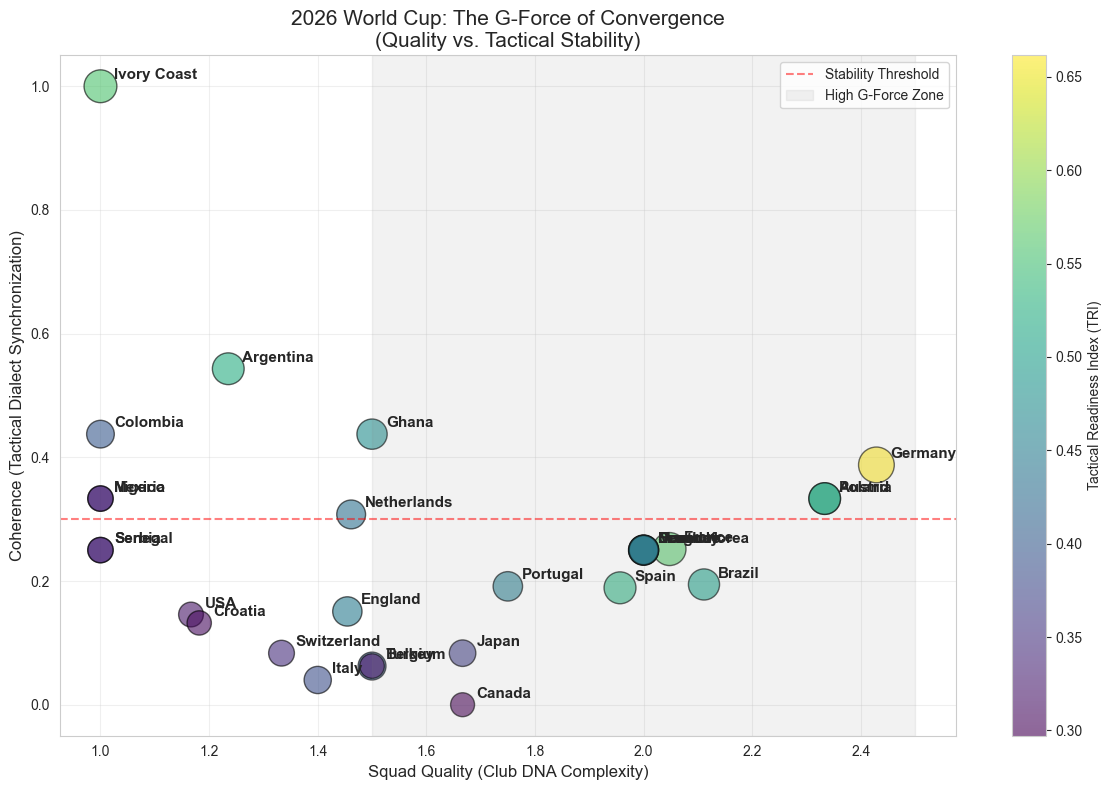

>>> Analysis Complete: G-Force Convergence Plot generated.


In [22]:
run_tournament_analysis(tri_results)

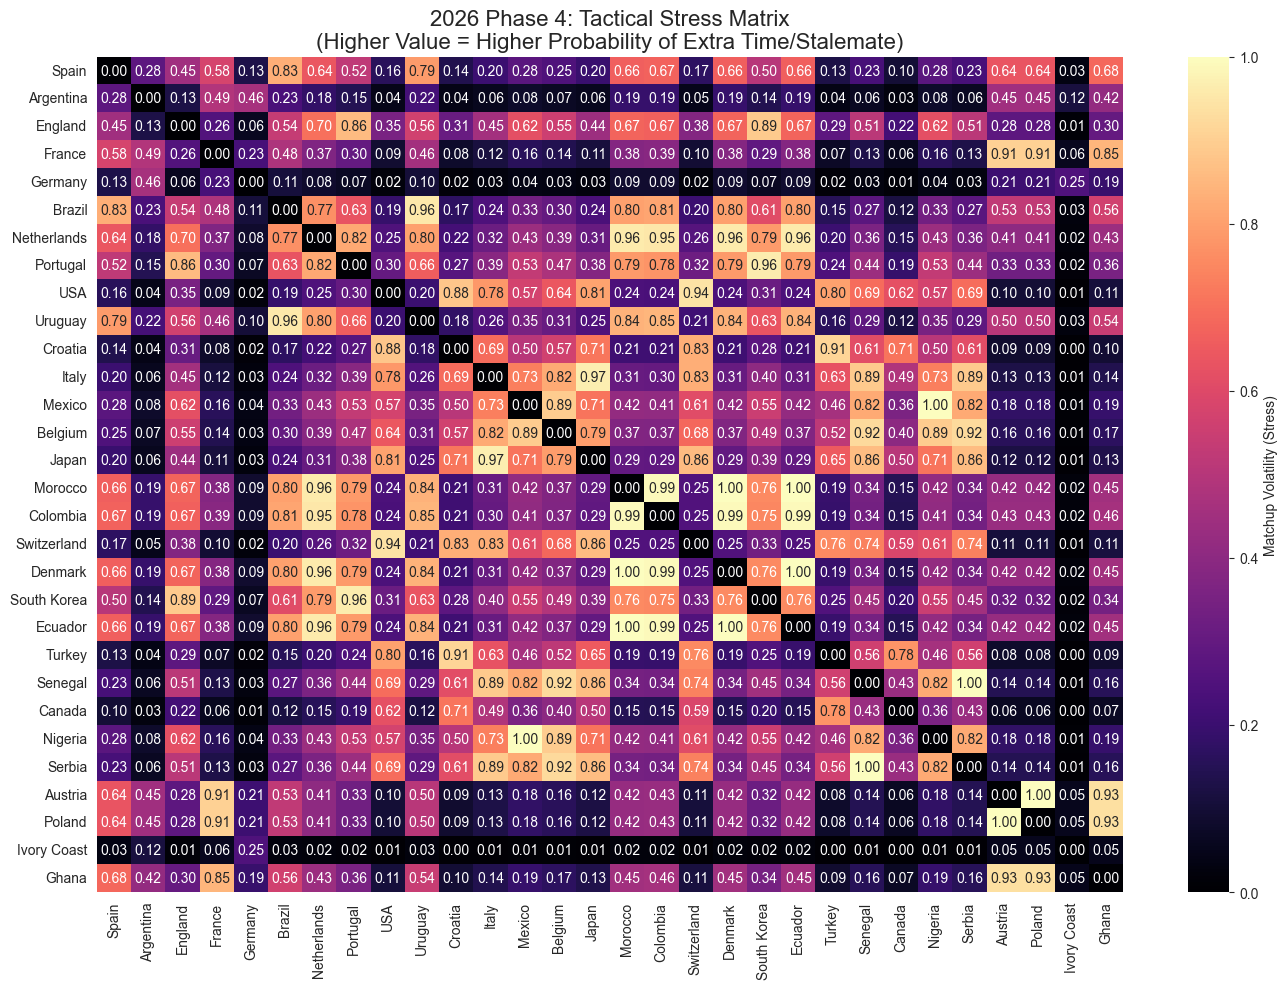

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def generate_stress_matrix(tri_results):
    """
    Generates a heatmap showing the 'Stress' level of potential matchups.
    Stress is defined by how close two teams are in Tactical Power.
    """
    nations = list(tri_results.keys())
    
    # 1. Calculate the 'Power Score' for each nation
    # This is the operational effectiveness of their tournament press
    power = {n: tri_results[n]['tri'] * (1 + tri_results[n]['coherence']) for n in nations}
    
    # 2. Create the Stress Matrix
    # We use an exponential decay of the difference: Stress = e^(-k * |diff|)
    # This ensures that as the gap in quality grows, the 'Stress' (tightness) drops rapidly.
    stress_data = pd.DataFrame(index=nations, columns=nations)
    
    for n1 in nations:
        for n2 in nations:
            if n1 == n2:
                stress_data.loc[n1, n2] = 0.0 # Ignore self-matchups
            else:
                diff = abs(power[n1] - power[n2])
                # High score (1.0) = identical power = maximum tactical stress
                stress_val = np.exp(-7 * diff) 
                stress_data.loc[n1, n2] = stress_val

    stress_data = stress_data.astype(float)

    # 3. Visualization
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        stress_data, 
        annot=True, 
        cmap="magma", 
        fmt=".2f", 
        cbar_kws={'label': 'Matchup Volatility (Stress)'}
    )
    
    plt.title("2026 Phase 4: Tactical Stress Matrix\n(Higher Value = Higher Probability of Extra Time/Stalemate)", fontsize=16)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    generate_stress_matrix(tri_results)

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets
import numpy as np

def scouting_report(Team_A, Team_B):
    if Team_A == Team_B:
        return "⚠️ Pick two different nations to scout the matchup."

    # 1. Calculate Power Scores (same logic as your matrix)
    # tri_results must be defined in your notebook
    p1 = tri_results[Team_A]['tri'] * (1 + tri_results[Team_A]['coherence'])
    p2 = tri_results[Team_B]['tri'] * (1 + tri_results[Team_B]['coherence'])
    
    # 2. Matchup Stress
    diff = abs(p1 - p2)
    stress = np.exp(-7 * diff)
    
    # 3. Formulate the Verdict
    print(f"📊 DATA SCOUT: {Team_A} vs {Team_B}")
    print(f"Tactical Stress Score: {stress:.2f}")
    print("-" * 40)
    
    if stress > 0.85:
        return "💎 VERDICT: WORTH WATCHING. Total tactical parity. Expect a stalemate/Extra Time."
    elif stress > 0.50:
        return "📺 VERDICT: GOOD MATCHUP. Highly competitive. One mistake settles it."
    elif stress > 0.20:
        winner = Team_A if p1 > p2 else Team_B
        return f"⚖️ VERDICT: MEH. {winner} has the structural edge. Likely a 2-0 win."
    else:
        winner = Team_A if p1 > p2 else Team_B
        return f"🚫 VERDICT: SKIP. {winner} will steamroll. Total tactical mismatch."

# Generate the dropdowns automatically from your tri_results keys
nations = sorted(list(tri_results.keys()))

interact(scouting_report, 
         Team_A=widgets.Dropdown(options=nations, value=nations[0]), 
         Team_B=widgets.Dropdown(options=nations, value=nations[1]))

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/56/6d/0d9848617b9f753b87f214f1c682592f7ca42de085f564352f10f0843026/ipywidgets-8.1.8-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.14 from https://files.pythonhosted.org/packages/3f/0e/fa3b193432cfc60c93b42f3be03365f5f909d2b3ea410295cf36df739e31/widgetsnbextension-4.0.15-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab_widgets~=3.0.15 from https://files.pythonhosted.org/packages/ab/b5/36c712098e6191d1b4e349304ef73a8d06aed77e56ceaac8c0a306c7bda1/jupyterlab_widgets-3.0.16-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 7.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update

Output()